# Libraries

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
from matplotlib.ticker import LinearLocator,MultipleLocator, AutoMinorLocator
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['text.usetex'] = True
rcParams['font.size'] = 20

In [2]:
PI=np.pi

# Functions

### DOS: $~~~~~\Lambda(E)=\frac{2}{\pi}\frac{E}{\sqrt{E^2-\Delta^2}\sqrt{J^2+\Delta^2-E^2}}~\Theta(E-\Delta)\Theta(\sqrt{J^2+\Delta^2}-E)$

In [4]:
def DOS(E,gap):
    return (2/PI)*E/(np.sqrt(np.abs(E**2-gap**2))*np.sqrt(np.abs(1+gap**2-E**2)))
def DOS2(E,Ep,gap):
    return (4.0/PI**2)*(E/(np.sqrt(np.abs(E**2-gap**2))*np.sqrt(np.abs(1+gap**2-E**2))))*(Ep/(np.sqrt(np.abs(Ep**2-gap**2))*np.sqrt(np.abs(1+gap**2-Ep**2))))

### Photonic spectral function: $~~~~~\mathrm{Im}D^R_{0}(\omega)=-\frac{1}{4\pi}\left[\frac{\gamma_B}{(\omega-\nu_0)^2+\gamma_B^2}-\frac{\gamma_B}{(\omega+\nu_0)^2+\gamma_B^2}\right]$

In [5]:
def ImDR0(w,nu0,gammaB):
    return -(1.0/(4.0*PI))*((gammaB/((w-nu0)**2+gammaB**2))-(gammaB/((w+nu0)**2+gammaB**2)))

### Distribution factor: $~~~~~H_0(\omega,\omega')=-4\left[n_0(\omega)-n_0(\omega')\right]\left[N_{T_{\rm cav}}(\omega-\omega')-N_{T_{\rm cry}}(\omega-\omega')\right]$

In [6]:
def H0(w,wp,Tcry,Tcav):
    return (np.tanh(wp/(2*Tcry))- np.tanh(w/(2*Tcry)))*((1.0/np.tanh((wp-w)/(2*Tcav)))-(1.0/np.tanh((wp-w)/(2*Tcry))))

#### calculates $\delta F(E)=-2\,\delta n(E)$

In [7]:
def delF_SC_integ(Ep,E,gap,Tcry,Tcav,gammaB,nu0):
    return  DOS(Ep,gap)*((1+(gap**2)/(E*Ep))*ImDR0(Ep-E,nu0,gammaB)*H0(E,Ep,Tcry,Tcav)-(1-(gap**2)/(E*Ep))*ImDR0(Ep+E,nu0,gammaB)*H0(-E,Ep,Tcry,Tcav))
def delF_SC(E,gap,Tcry,Tcav,gammaB,nu0,g0,gamma):
    return -(g0**2/gamma)*sp.integrate.quad(delF_SC_integ,gap,np.sqrt(1+gap**2),args=(E,gap,Tcry,Tcav,gammaB,nu0))[0]
def delF_CDW_integ(Ep,E,gap,Tcry,Tcav,gammaB,nu0):
    return  DOS(Ep,gap)*((1-(gap**2)/(E*Ep))*ImDR0(Ep-E,nu0,gammaB)*H0(E,Ep,Tcry,Tcav)-(1+(gap**2)/(E*Ep))*ImDR0(Ep+E,nu0,gammaB)*H0(-E,Ep,Tcry,Tcav))
def delF_CDW(E,gap,Tcry,Tcav,gammaB,nu0,g0,gamma):
    return -(g0**2/gamma)*sp.integrate.quad(delF_CDW_integ,gap,np.sqrt(1+gap**2),args=(E,gap,Tcry,Tcav,gammaB,nu0))[0]

## Gap equation

In [8]:
# The Numerataors
#SC
def num_integ_SC(E,Ep,gap,Tcry,Tcav,gammaB,nu0):
    return (DOS2(E,Ep,gap)/E)*((1+(gap**2)/(E*Ep))*ImDR0(Ep-E,nu0,gammaB)*H0(E,Ep,Tcry,Tcav)-(1-(gap**2)/(E*Ep))*ImDR0(Ep+E,nu0,gammaB)*H0(-E,Ep,Tcry,Tcav))
def numSC(eps,gap,Tcry,Tcav,gammaB,nu0):
    return sp.integrate.dblquad(num_integ_SC,gap,np.sqrt(1+gap**2),gap,lambda x: x,args=(gap,Tcry,Tcav,gammaB,nu0),epsabs=eps)[0]+sp.integrate.dblquad(num_integ_SC,gap,np.sqrt(1+gap**2),lambda x: x,np.sqrt(1+gap**2),args=(gap,Tcry,Tcav,gammaB,nu0),epsabs=eps)[0]
#CDW
def num_integ_CDW(E,Ep,gap,Tcry,Tcav,gammaB,nu0):
    return (DOS2(E,Ep,gap)/E)*((1-(gap**2)/(E*Ep))*ImDR0(Ep-E,nu0,gammaB)*H0(E,Ep,Tcry,Tcav)-(1+(gap**2)/(E*Ep))*ImDR0(Ep+E,nu0,gammaB)*H0(-E,Ep,Tcry,Tcav))
def numCDW(eps,gap,Tcry,Tcav,gammaB,nu0):
    return sp.integrate.dblquad(num_integ_CDW,gap,np.sqrt(1+gap**2),gap,lambda x: x,args=(gap,Tcry,Tcav,gammaB,nu0),epsabs=eps)[0]+sp.integrate.dblquad(num_integ_CDW,gap,np.sqrt(1+gap**2),lambda x: x,np.sqrt(1+gap**2),args=(gap,Tcry,Tcav,gammaB,nu0),epsabs=eps)[0]

In [9]:
def gap_eq_integ(E,gap,T):
    return (DOS(E,gap)/E)*np.tanh(E/(2*T))
def gap_eq(gap,T,kap):
    return sp.integrate.quad(gap_eq_integ,gap,np.sqrt(1+gap**2),args=(gap,T))[0]-1.0/kap
def gap_eq_inv(T,gap,kap):
    return sp.integrate.quad(gap_eq_integ,gap,np.sqrt(1+gap**2),args=(gap,T))[0]-1.0/kap

In [10]:
#SC
def gap_nth_SC(gap,Tcry,kap,g0,gamma,gammaB,Tcav,nu0,eps):
    return gap_eq(gap,Tcry,kap)-(g0**2/gamma)*numSC(eps,gap,Tcry,Tcav,gammaB,nu0)
def gap_nth_SC_inv(Tcry,gap,kap,g0,gamma,gammaB,Tcav,nu0,eps):
    return gap_eq(gap,Tcry,kap)-(g0**2/gamma)*numSC(eps,gap,Tcry,Tcav,gammaB,nu0)
#CDW
def gap_nth_CDW(gap,Tcry,kap,g0,gamma,gammaB,Tcav,nu0,eps):
    return gap_eq(gap,Tcry,kap)-(g0**2/gamma)*numCDW(eps,gap,Tcry,Tcav,gammaB,nu0)
def gap_nth_CDW_inv(Tcry,gap,kap,g0,gamma,gammaB,Tcav,nu0,eps):
    return gap_eq(gap,Tcry,kap)-(g0**2/gamma)*numCDW(eps,gap,Tcry,Tcav,gammaB,nu0)

# Generate data

In [11]:
KAP=0.5
TCAV=0.2
G0=0.1
GAMMA=0.01
GAMMAB=0.5
EPS=0.00001
TCRY=0.094
GAP=0.05
EPS=0.00001
NE=100
Elist=np.linspace(GAP,np.sqrt(1+GAP**2),NE)

## Set $T_{\rm cry}$ deep in the ordered phase

In [ ]:
TC0=sp.optimize.fsolve(gap_eq_inv,0.1,args=(0.0,KAP))[0]
TCRYSC=0.7*TC0
TCRYCDW=0.7*TC0
GAP0SC=sp.optimize.fsolve(gap_eq,0.1,args=(TCRYSC,KAP))[0]
GAP0CDW=sp.optimize.fsolve(gap_eq,0.1,args=(TCRYCDW,KAP))[0]

## Calculate $\Delta$ vs $\nu_0$ deep in the ordered phase

In [ ]:
NNU0=25
NUlist=np.array([0.02*i for i in range (0,NNU0)])
NUlist[0]=0.001

gapSC=np.zeros([NNU0])
gapCDW=np.zeros([NNU0])

NU0=NUlist[0]
gapSC[0]=sp.optimize.fsolve(gap_nth_SC,GAP0SC,args=(TCRYSC,KAP,G0,GAMMA,GAMMAB*NU0,TCAV,NU0,EPS))[0]
gapCDW[0]=sp.optimize.fsolve(gap_nth_CDW,GAP0CDW,args=(TCRYCDW,KAP,G0,GAMMA,GAMMAB*NU0,TCAV,NU0,EPS))[0]
for k in range(1,NNU0):
    NU0=NUlist[k]
    gapSC[k]=sp.optimize.fsolve(gap_nth_SC,gapSC[k-1],args=(TCRYSC,KAP,G0,GAMMA,GAMMAB*NU0,TCAV,NU0,EPS))[0]
    gapCDW[k]=sp.optimize.fsolve(gap_nth_CDW,gapCDW[k-1],args=(TCRYCDW,KAP,G0,GAMMA,GAMMAB*NU0,TCAV,NU0,EPS))[0]

In [38]:
outfname=("./data/GapVsNu_g%.2f_gam%.2f_gamB%.2f_Tcav%.2f_Tcry%.2f.dat"%(G0,GAMMA,GAMMAB,TCAV,TCRYSC/TC0))    
file=open(outfname,"a")
file.write("#NU\t\tGAP_EQ\t\tGAP_SC\t\tGAP_CDW\n")
for i in range(0,NNU0):
    file.write("%lf\t%lf\t%lf\t%lf\n" %(NUlist[i],GAP0SC,gapSC[i],gapCDW[i]))
file.close()

## Calculate $\delta F(E)=-2\,\delta n(E)$ vs $E$ at fixed $\nu_0$ values

In [ ]:
NUinx=np.array([2,20],dtype='int')
gapSCsl=np.zeros([2])
gapCDWsl=np.zeros([2])


NE=100
ElistSC=np.zeros([2,NE])
ElistCDW=np.zeros([2,NE])
delFSClist=np.zeros([2,NE])
delFCDWlist=np.zeros([2,NE])

for k in range(0,2):
    inx=NUinx[k]
    NU0=NUlist[inx]
    gapSCsl[k]=gapSC[inx]
    gapCDWsl[k]=gapCDW[inx]
    ElistSC[k,:]=np.linspace(gapSCsl[k],np.sqrt(1+gapSCsl[k]**2),NE)
    ElistCDW[k,:]=np.linspace(gapCDWsl[k],np.sqrt(1+gapCDWsl[k]**2),NE)
    for j in range(0,NE):
        delFSClist[k,j]=delF_SC(ElistSC[k,j],gapSCsl[k],TCRYSC,TCAV,GAMMAB*NU0,NU0,G0,GAMMA)
        delFCDWlist[k,j]=delF_CDW(ElistCDW[k,j],gapCDWsl[k],TCRYCDW,TCAV,GAMMAB*NU0,NU0,G0,GAMMA)

# Plots

<Figure size 1920x1440 with 0 Axes>

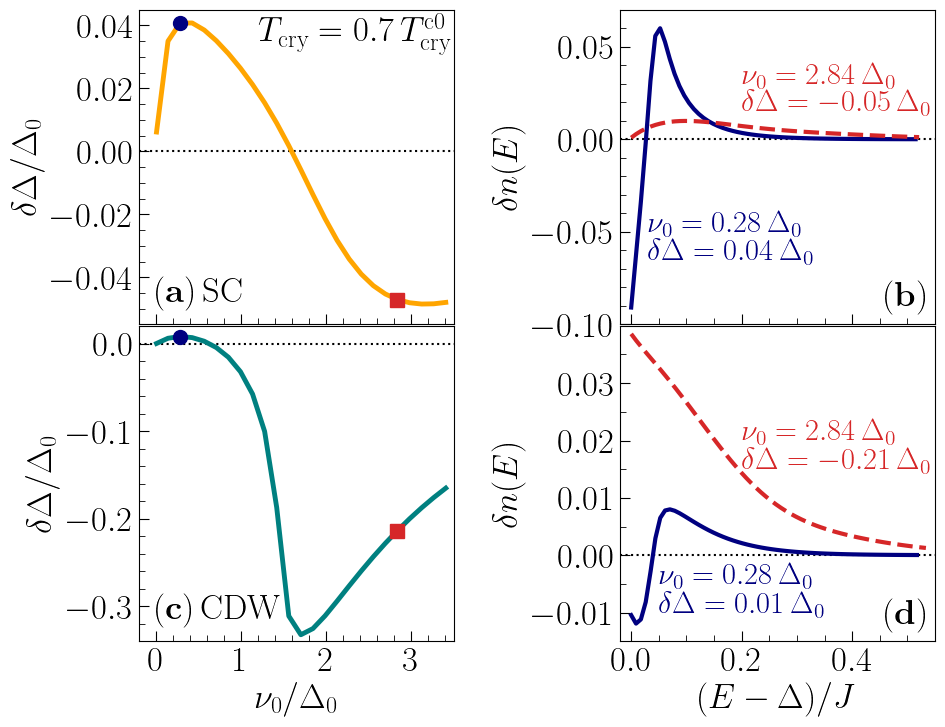

In [173]:
plt.figure(1,dpi=300)
plt.rcParams.update({'font.size':25})

clrs=['deepskyblue','darkgreen','saddlebrown','navy']
lw=3.0
clrs=plt.cm.viridis_r(np.linspace(0.2,0.9,3))
NEmax=(int)(0.6*NE)

fig,ax=plt.subplots(2,2,figsize=(10,10))

ax[0,1].axhline(y=0.0,linestyle=":",linewidth=1.5,color="black")
ax[1,1].axhline(y=0.0,linestyle=":",linewidth=1.5,color="black")
ax[0,0].axhline(y=0.0,linestyle=":",linewidth=1.5,color="black")
ax[1,0].axhline(y=0.0,linestyle=":",linewidth=1.5,color="black")


ax[0,0].plot(NUlist/GAP0SC,(gapSC-GAP0SC)/GAP0SC,'-',color='orange',markersize=8,linewidth=lw+0.5)
ax[1,0].plot(NUlist/GAP0CDW,(gapCDW-GAP0CDW)/GAP0CDW,'-',color='teal',markersize=8,linewidth=lw+0.5)

ax[0,0].plot(NUlist[NUinx[0]]/GAP0SC,(gapSC[NUinx[0]]-GAP0SC)/GAP0SC,'o',color='navy',markersize=10,linewidth=lw)
ax[0,0].plot(NUlist[NUinx[1]]/GAP0SC,(gapSC[NUinx[1]]-GAP0SC)/GAP0SC,'s',color='tab:red',markersize=10,linewidth=lw)
ax[1,0].plot(NUlist[NUinx[0]]/GAP0SC,(gapCDW[NUinx[0]]-GAP0SC)/GAP0SC,'o',color='navy',markersize=10,linewidth=lw)
ax[1,0].plot(NUlist[NUinx[1]]/GAP0SC,(gapCDW[NUinx[1]]-GAP0SC)/GAP0SC,'s',color='tab:red',markersize=10,linewidth=lw)


ax[0,1].plot(ElistSC[0,:NEmax]-gapSCsl[0],-0.5*delFSClist[0,:NEmax],'-',color='navy',linewidth=lw,label=r"$\nu_0=%.3fJ,~\delta \Delta/\Delta_0=%.2f$"%(NUlist[0],(gapSC[0]-GAP0SC)/GAP0SC))
ax[0,1].plot(ElistSC[1,:NEmax]-gapSCsl[1],-0.5*delFSClist[1,:NEmax],'--',color='tab:red',linewidth=lw,label=r"$\nu_0=%.3fJ,~\delta \Delta/\Delta_0=%.2f$"%(NUlist[1],(gapSC[1]-GAP0SC)/GAP0SC))
ax[1,1].plot(ElistCDW[0,:NEmax]-gapCDWsl[0],-0.5*delFCDWlist[0,:NEmax],'-',color='navy',linewidth=lw,label=r"$\nu_0=%.3fJ,~\delta \Delta/\Delta_0=%.2f$"%(NUlist[0],(gapCDW[0]-GAP0CDW)/GAP0CDW))
ax[1,1].plot(ElistCDW[1,:NEmax]-gapCDWsl[1],-0.5*delFCDWlist[1,:NEmax],'--',color='tab:red',linewidth=lw,label=r"$\nu_0=%.3fJ,~\delta \Delta/\Delta_0=%.2f$"%(NUlist[1],(gapCDW[1]-GAP0CDW)/GAP0CDW))




ax[0,0].set_ylabel(r'$\delta \Delta/\Delta_0$')
ax[1,0].set_xlabel(r'$\nu_0/\Delta_0$')
ax[1,0].set_ylabel(r'$\delta \Delta/\Delta_0$')
ax[0,1].set_ylabel(r'$\delta n(E)$')
ax[1,1].set_xlabel(r'$(E-\Delta)/J$')
ax[1,1].set_ylabel(r'$\delta n(E)$')
ax[0,0].set_xticklabels([])
ax[0,1].set_xticklabels([])

ax[0,0].text(0.002,-0.048,r'$\mathbf{(a)}\,\mathrm{SC}$')
ax[1,0].text(0.002,-0.315,r'$\mathbf{(c)}\,\mathrm{CDW}$')
ax[0,0].text(1.2,0.035,r'$T_{\mathrm{cry}}=%.1f\,T^{\mathrm{c}0}_{\mathrm{cry}}$'%(TCRYSC/TC0))


ax[0,1].text(0.46,-0.09,r'$\mathbf{(b)}$')
ax[1,1].text(0.46,-0.012,r'$\mathbf{(d)}$')


ax[0,1].text(0.03,-0.05,r"$\nu_0=%.2f\,\Delta_0$"%(NUlist[NUinx[0]]/GAP0SC),color='navy',fontsize=22)
ax[0,1].text(0.03,-0.065,r"$\delta \Delta=%.2f\,\Delta_0$"%((gapSC[NUinx[0]]-GAP0SC)/GAP0SC),color='navy',fontsize=22)
ax[0,1].text(0.2,0.03,r"$\nu_0=%.2f\,\Delta_0$"%(NUlist[NUinx[1]]/GAP0SC),color='tab:red',fontsize=22)
ax[0,1].text(0.2,0.015,r"$\delta \Delta=%.2f\,\Delta_0$"%((gapSC[NUinx[1]]-GAP0SC)/GAP0SC),color='tab:red',fontsize=22)

ax[1,1].text(0.05,-0.005,r"$\nu_0=%.2f\,\Delta_0$"%(NUlist[NUinx[0]]/GAP0SC),color='navy',fontsize=22)
ax[1,1].text(0.05,-0.01,r"$\delta \Delta=%.2f\,\Delta_0$"%((gapCDW[NUinx[0]]-GAP0SC)/GAP0SC),color='navy',fontsize=22)
ax[1,1].text(0.2,0.02,r"$\nu_0=%.2f\,\Delta_0$"%(NUlist[NUinx[1]]/GAP0SC),color='tab:red',fontsize=22)
ax[1,1].text(0.2,0.015,r"$\delta \Delta=%.2f\,\Delta_0$"%((gapCDW[NUinx[1]]-GAP0SC)/GAP0SC),color='tab:red',fontsize=22)


xmin0=-0.2
xmax0=3.5
ax[0,0].set_xlim(xmin0,xmax0)
ax[1,0].set_xlim(xmin0,xmax0)
xmin1=-0.02
xmax1=0.55
ax[0,1].set_xlim(xmin1,xmax1)
ax[1,1].set_xlim(xmin1,xmax1)
ymin00=-0.055
ymax00=0.045
ymin10=-0.34
ymax10=0.02
ax[0,0].set_ylim(ymin00,ymax00)
ax[1,0].set_ylim(ymin10,ymax10)
ymin01=-0.1
ymax01=0.07
ymin11=-0.015
ymax11=0.0399
ax[0,1].set_ylim(ymin01,ymax01)
ax[1,1].set_ylim(ymin11,ymax11)


ax[0,0].tick_params(which='major',direction='in', length=7)
ax[0,0].tick_params(which='minor',direction='in', length=4)
ax[0,0].xaxis.set_major_locator(MultipleLocator(1))
ax[0,0].xaxis.set_minor_locator(MultipleLocator(0.2))
ax[0,0].yaxis.set_major_locator(MultipleLocator(0.02))
ax[0,0].yaxis.set_minor_locator(MultipleLocator(0.005))
ax[1,0].tick_params(which='major',direction='in', length=7)
ax[1,0].tick_params(which='minor',direction='in', length=4)
ax[1,0].xaxis.set_major_locator(MultipleLocator(1))
ax[1,0].xaxis.set_minor_locator(MultipleLocator(0.2))
ax[1,0].yaxis.set_major_locator(MultipleLocator(0.1))
ax[1,0].yaxis.set_minor_locator(MultipleLocator(0.02))

ax[0,1].tick_params(which='major',direction='in', length=7)
ax[0,1].tick_params(which='minor',direction='in', length=4)
ax[0,1].xaxis.set_major_locator(MultipleLocator(0.2))
ax[0,1].xaxis.set_minor_locator(MultipleLocator(0.05))
ax[0,1].yaxis.set_major_locator(MultipleLocator(0.05))
ax[0,1].yaxis.set_minor_locator(MultipleLocator(0.01))
ax[1,1].tick_params(which='major',direction='in', length=7)
ax[1,1].tick_params(which='minor',direction='in', length=4)
ax[1,1].xaxis.set_major_locator(MultipleLocator(0.2))
ax[1,1].xaxis.set_minor_locator(MultipleLocator(0.05))
ax[1,1].yaxis.set_major_locator(MultipleLocator(0.01))
ax[1,1].yaxis.set_minor_locator(MultipleLocator(0.005))

ax[0,0].set_box_aspect(1)
ax[1,0].set_box_aspect(1)
ax[0,1].set_box_aspect(1)
ax[1,1].set_box_aspect(1)

plt.subplots_adjust(hspace=-0.9)
plt.tight_layout()
plt.savefig("./plots/delgapn_g%.2f_gam%.2f_gamB%.2f_Tcav%.2f_Tcry%.2fTc0.pdf"%(G0,GAMMA,GAMMAB,TCAV,TCRYSC/TC0),dpi=300)
plt.savefig("./plots/delgapn_panel.pdf",dpi=300)
plt.show()